In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from einops import rearrange, repeat

## Check for GPU

In [2]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Get data

In [3]:
cifar100 = torchvision.datasets.CIFAR100(root='./', download=True)

Files already downloaded and verified


In [4]:
transform = transforms.Compose([
    # transforms.Resize((128, 128)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert PIL Images to tensors
])

# Assuming celeba is your dataset, apply the transform
cifar100.transform = transform

In [5]:
batch_size = 16
cifar_loader = torch.utils.data.DataLoader(cifar100,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=12)

## Plot data

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

def show_batch(images, is_patches=True, patch_grid=None, line_width=1, line_color=(0, 0, 0)):
    """
    Display a batch of images or image patches with grid lines separating patches.
    
    Args:
        images (torch.Tensor): Batch of images or patches.
                               - For full images: Shape [B, C, H, W].
                               - For patches: Shape [B, num_patches, patch_height, patch_width, C].
        is_patches (bool): Whether the input is patches (default: True).
        patch_grid (tuple): Grid dimensions for patches (e.g., (16, 16) for 256 patches).
                            Required if `is_patches=True`.
        line_width (int): Width of the grid lines separating patches (default: 1).
        line_color (tuple): Color of the grid lines in RGB format (default: (0, 0, 0) for black).
    """
    # Convert images to numpy and move channel dimension to the end
    if is_patches:
        # Handle patches: reshape into a grid
        assert patch_grid is not None, "patch_grid must be provided for patches"
        
        # Reshape patches into a grid
        B, num_patches, pH, pW, C = images.shape
        images = rearrange(images, 'b (gh gw) ph pw c -> b (gh ph) (gw pw) c', gh=patch_grid[0], gw=patch_grid[1])
        images = images.cpu()
        
        # Add grid lines between patches
        if line_width > 0:
            B, H, W, C = images.shape
            gh, gw = patch_grid
            new_H = H + (gh - 1) * line_width
            new_W = W + (gw - 1) * line_width
            
            # Convert PyTorch dtype to NumPy dtype
            dtype = images.dtype
            if dtype == torch.float32:
                dtype = np.float32
            elif dtype == torch.uint8:
                dtype = np.uint8
            else:
                raise ValueError(f"Unsupported dtype: {dtype}")
            
            new_images = np.zeros((B, new_H, new_W, C), dtype=dtype)
            
            # Convert PyTorch tensor to NumPy array before assignment
            images_np = images.numpy()
            
            for i in range(gh):
                for j in range(gw):
                    y_start = i * (pH + line_width)
                    x_start = j * (pW + line_width)
                    new_images[:, y_start:y_start+pH, x_start:x_start+pW, :] = images_np[:, i*pH:(i+1)*pH, j*pW:(j+1)*pW, :]
            
            images = new_images
    else:
        # Handle full images
        images = rearrange(images, 'b c h w -> b h w c')
        images = images.cpu().numpy()
    
    # Get number of images in batch
    batch_size = images.shape[0]
    
    # Create figure
    fig, axes = plt.subplots(1, batch_size, figsize=(12, 3))
    if batch_size == 1:
        axes = [axes]
    
    # Plot each image
    for idx, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        ax.axis('off')
    
    plt.tight_layout()
    return fig

In [7]:
# Get a batch of images and their corresponding names
dataiter = iter(cifar_loader)
images, _ = next(dataiter)
images = images.to(device)

## Model architecture

In [8]:
C = images.shape[1]
H = images.shape[2]
W = images.shape[3]
patch_size = 8
num_patches = H*W // patch_size**2
emb_dim = 768
num_heads = 12
print(f"Number of channels (C): {C}")
print(f"Height (H): {H}")
print(f"Width (W): {W}")
print(f"Patch size (patch_size): {patch_size}")
print(f"Number of patches (num_patches): {num_patches}")
print(f"Embedding dimension (emb_dim): {emb_dim}")
print(f"Number of heads (num_heads): {num_heads}")
print(f"Head dimension: {emb_dim // num_heads}")

Number of channels (C): 3
Height (H): 32
Width (W): 32
Patch size (patch_size): 8
Number of patches (num_patches): 16
Embedding dimension (emb_dim): 768
Number of heads (num_heads): 12
Head dimension: 64


In [9]:
images.shape

torch.Size([16, 3, 32, 32])

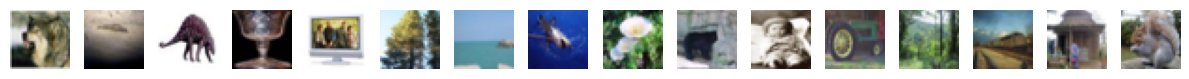

In [10]:
fig = show_batch(images.cpu(), is_patches=False)

## Patch 

In [11]:
import torch
import torch.nn as nn
from einops import rearrange, repeat

class Patchify(nn.Module):
    def __init__(self, patch_size: int, C: int, img_shape: tuple, emb_dim: int):
        """
        Args:
            patch_size (int): Size of each patch (height and width).
            C (int): Number of input channels.
            img_shape (tuple): Shape of the input image (height, width).
            emb_dim (int): Dimension of the patch embeddings.
        """
        super(Patchify, self).__init__()
        self.patch_size = patch_size
        self.C = C
        self.h, self.w = img_shape
        self.emb_dim = emb_dim
        
        # Calculate the number of patches
        self.num_patches = (self.h // patch_size) * (self.w // patch_size)
        
        # Learnable class token (shape: (1, emb_dim))
        self.class_token = nn.Parameter(torch.randn(1, emb_dim))
        
        # Learnable positional embeddings (shape: (1, num_patches + 1, emb_dim))
        self.pos_emb = nn.Parameter(torch.randn(1, self.num_patches + 1, emb_dim))
        
        # Linear projection layer (if patch embedding dimension != emb_dim)
        self.proj = nn.Linear(patch_size * patch_size * C, emb_dim) if patch_size * patch_size * C != emb_dim else nn.Identity()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Input image tensor of shape (batch_size, C, H, W).
        
        Returns:
            torch.Tensor: Patch embeddings with class token and positional embeddings,
                          of shape (batch_size, num_patches + 1, emb_dim).
        """
        # Patchify the image: (batch_size, C, H, W) -> (batch_size, num_patches, patch_size * patch_size * C)
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        
        # Project patch embeddings to the embedding dimension (if necessary)
        x = self.proj(x)  # Shape: (batch_size, num_patches, emb_dim)
        
        # Get batch size dynamically
        batch_size = x.shape[0]
        
        # Expand class token to match batch size: (1, emb_dim) -> (batch_size, 1, emb_dim)
        class_token = repeat(self.class_token, '1 d -> b 1 d', b=batch_size)
        
        # Prepend the class token to the patch embeddings
        x = torch.cat([class_token, x], dim=1)  # Shape: (batch_size, num_patches + 1, emb_dim)
        
        # Add positional embeddings
        x = x + self.pos_emb  # Shape: (batch_size, num_patches + 1, emb_dim)
        
        return x

In [12]:
patchify = Patchify(patch_size=patch_size, C=C, img_shape=(H,W), emb_dim=emb_dim).to(device)
patches = patchify(images)
patches.shape

torch.Size([16, 17, 768])

In [13]:
import torch.nn.functional as F
class MHSA(nn.Module):
    def __init__(self, num_heads, emb_dim):
        super(MHSA, self).__init__()
        self.num_heads = num_heads
        self.emb_dim = emb_dim
        self.head_dim = emb_dim // num_heads 
        self.wq = nn.Linear(emb_dim, emb_dim)
        self.wk = nn.Linear(emb_dim, emb_dim)
        self.wv = nn.Linear(emb_dim, emb_dim)
        
    def forward(self, x):
        batch_size, num_patches_plus_1, emb_dim = x.shape
        q = self.wq(x) ## bs, num_patches + 1, emb_dim
        k = self.wk(x) ## bs, num_patches + 1, emb_dim
        v = self.wv(x) ## bs, num_patches + 1, emb_dim
        q = rearrange(q, 'bs patches_plus_1 (num_heads head_size) -> bs num_heads patches_plus_1 head_size', num_heads=self.num_heads, head_size=self.head_dim)
        k = rearrange(k, 'bs patches_plus_1 (num_heads head_size) -> bs num_heads patches_plus_1 head_size', num_heads=self.num_heads, head_size=self.head_dim)
        v = rearrange(v, 'bs patches_plus_1 (num_heads head_size) -> bs num_heads patches_plus_1 head_size', num_heads=self.num_heads, head_size=self.head_dim)
        attention_scores = q @ torch.transpose(k,-1,-2) * (self.head_dim ** -0.5)
        attention_scores = F.softmax(attention_scores, dim=-1)
        output = attention_scores @ v
        output = rearrange(output, 'bs num_heads patch_size head_dim -> bs patch_size (head_dim num_heads)')
        return q, k, v, output
        

In [14]:
# mhsa = MHSA(num_heads, emb_dim).to(device)

In [15]:
# q, k, v, out = mhsa(patches)
# print(q.shape, k.shape, v.shape, out.shape)

torch.Size([16, 12, 17, 64]) torch.Size([16, 12, 17, 64]) torch.Size([16, 12, 17, 64]) torch.Size([16, 17, 768])


In [ ]:
class XformerLayer(nn.Module):
    def __init__(self, num_heads, emb_dim, hidden_dim):
        super(XformerLayer, self).__init__()
        self.num_heads = num_heads
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        
    def forward(self, x):
        batch_size, num_patches_plus_1, emb_dim = x.shape
        